In [139]:
#加载包和数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import time

# 数据的探索
在这一部分，你需要探索你将要使用的数据。数据可以是若干个数据集，或者输入数据/文件，甚至可以是一个设定环境。你需要详尽地描述数据的类型。如果可以的话，你需要展示数据的一些统计量和基本信息（例如输入的特征（features)，输入里与定义相关的特性，或者环境的描述）。你还要说明数据中的任何需要被关注的异常或有趣的性质（例如需要做变换的特征，离群值等等）。你需要考虑：

如果你使用了数据集，你要详尽地讨论了你所使用数据集的某些特征，并且为阅读者呈现一个直观的样本
如果你使用了数据集，你要计算并描述了它们的统计量，并对其中与你问题相关的地方进行讨论
如果你没有使用数据集，你需要对你所使用的输入空间（input space)或输入数据进行讨论？
数据集或输入中存在的异常，缺陷或其他特性是否得到了处理？(例如分类变数，缺失数据，离群值等）

# 数据导入

In [140]:
train_data=pd.read_csv('C:/Users/Raytine/Desktop/rossmann-store-sales/train.csv',low_memory=False)
test_data=pd.read_csv('C:/Users/Raytine/Desktop/rossmann-store-sales/test.csv',low_memory=False)
store_data=pd.read_csv('C:/Users/Raytine/Desktop/rossmann-store-sales/store.csv',low_memory=False)

# 数据观察

In [141]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [142]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [143]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


特征释义
1. Id:测试集内(商店、日期)的组合。
2. Store:表示每个商店的唯一Id。
3. Sales:任意一天的销售额，也是我们要预测的字段。
4. Open:是否开门，0=关门，1=开门。
5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
6. SchoolHoliday:校园假日，指当日学校是否关闭。
7. StoreType:商店类型，有四种，abcd。
8. Assortment:分类级别，a=基础，b=额外，c=扩展。
9. CompetitionDistance:竞争对手距离。
10. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
11. Promo:表示商店当天是否进行促销
12. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
13. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
14. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

从数据观察的结果来看，销售包含的日期数据，但是格式是文本的，需要将其转化为日期格式才能进行运算。
店铺的StoreType 和Assortment 两个特征，都是枚举值，后期可以转化为One-Hot编码。
DayOfWeek特征并不能直接用数字去理解，需要后期调整。

# 缺失值查看

In [144]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


store表关于促销和竞争者数据部分有缺失。
先看竞争者的缺失情况，距离方面，缺少了3家，开业时间方面，缺少了354家。先确认距离方面缺少的3家是不是后面的时间特征也缺了。


In [145]:
store_data[pd.isnull(store_data['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


的确是都缺少了，距离方面用其他商店的均值补充。那么剩下的开业年月也用其他的均值补充。

下面再看促销日期的特征，虽然3个特征都缺失了544个，但是还需要确认下是否都缺在相同的店铺上。

In [146]:
store_data[(pd.isnull(store_data['Promo2SinceWeek']))&(pd.isnull(store_data['Promo2SinceYear']))
           &(pd.isnull(store_data['PromoInterval']))]['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

的确都是相同的店铺，而且都是因为没有促销导致的缺失，那么store表的数据缺失情况基本就清楚了。

In [147]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


train表中没有缺失数据。

In [148]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


test表中缺失了一些open特征的数据，一共是11个，下面看一下具体情况

In [149]:
test_data[pd.isnull(test_data['Open'])]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


都是同一家店铺，可能是数据缺了，到时候直接用开业来补全。

# 特征分析

In [150]:
#数据合并

In [151]:
train_data=pd.merge(train_data,store_data,on='Store',how='left')

In [152]:
test_data=pd.merge(test_data,store_data,on='Store',how='left')

In [153]:
#数据补充

In [154]:
#test表Open特征都补充为1
test_data.Open.fillna(1,inplace=True)

In [155]:
#train/test表的CompetitionDistance特征用均值填充
train_data.CompetitionDistance.fillna(store_data.CompetitionDistance.mean(),inplace=True)
test_data.CompetitionDistance.fillna(store_data.CompetitionDistance.mean(),inplace=True)

In [156]:
#train/test表的Promo2SinceWeek\Promo2SinceYear\PromoInterval\CompetitionOpenSinceMonth\CompetitionOpenSinceYear特征用0填充试试
train_data.fillna(0,inplace=True)
test_data.fillna(0,inplace=True)

In [157]:
#日期转化为datetime 格式
train_data.Date = pd.to_datetime(train_data.Date)
test_data.Date = pd.to_datetime(test_data.Date)

# 创造衍生特征

In [158]:
shopavgopen=train_data[train_data['Open']==1].groupby('Store').agg({'Sales':'mean'}).rename(columns={'Sales':'shopavgopen'}).reset_index()
train_data=train_data.merge(shopavgopen,on='Store',how='left')
test_data=test_data.merge(shopavgopen,on='Store',how='left')

In [159]:
shopavgsalespercustomer=train_data[train_data['Open']==1].groupby('Store').agg({'Sales':'mean','Customers':'mean'})
shopavgsalespercustomer['shopavgsalespercustomer']=(shopavgsalespercustomer['Sales']/shopavgsalespercustomer['Customers'])
shopavgsalespercustomer=shopavgsalespercustomer.reset_index()[['Store','shopavgsalespercustomer']]
train_data=train_data.merge(shopavgsalespercustomer,on='Store',how='left')
test_data=test_data.merge(shopavgsalespercustomer,on='Store',how='left')

In [160]:
#shopavgschoolholiday=train_data[(train_data['Open']==1)&(train_data['SchoolHoliday']==1)].groupby('Store').agg({'Sales':'mean'}).reset_index()
#train_data=train_data.merge(shopavgschoolholiday,on='Store',how='left')

In [161]:
train_data['DayOfYear']=train_data.Date.map(lambda x :int(x.strftime('%j')))
train_data['Month']=train_data.Date.map(lambda x :int(x.strftime('%m')))
train_data['Week']=train_data.Date.map(lambda x :int(x.strftime('%W')))
train_data['Year']=train_data.Date.map(lambda x :int(x.strftime('%Y')))

In [162]:
plt.rcParams['font.sans-serif']=['SimHei']

In [163]:
def competition_open_month(data):
    data['CompetitionOpen'] = 12*(data.Year - data.CompetitionOpenSinceYear)+(data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x:x if x>0 else 0)

competition_open_month(train_data)    

In [164]:
def is_in_promo2(data):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
def get_promo2_months(data):
    data['PromoOpen'] = 12*(data.Year - data.Promo2SinceYear) + (data.Week - data.Promo2SinceWeek)/4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x>0 else 0)

is_in_promo2(train_data)
get_promo2_months(train_data)

In [165]:
def stateholiday(data):
    Holiday={'0':0,'a':1,'b':2,'c':3}
    data['StateHoliday'] = data.StateHoliday.map(Holiday)

In [166]:
stateholiday(train_data)

In [167]:
def storetype(data):
    storetype={'0':0,'a':1,'b':2,'c':3,'d':4}
    data['StoreType'] = data.StoreType.map(storetype)

In [168]:
def assortment(data):
    assortment={'0':0,'a':1,'b':2,'c':3,'d':4}
    data['Assortment'] = data.Assortment.map(assortment)

In [169]:
storetype(train_data)
assortment(train_data)

In [170]:
#按照train数据的结果，处理test数据
test_data['DayOfYear']=test_data.Date.map(lambda x :int(x.strftime('%j')))
test_data['Month']=test_data.Date.map(lambda x :int(x.strftime('%m')))
test_data['Week']=test_data.Date.map(lambda x :int(x.strftime('%W')))
test_data['Year']=test_data.Date.map(lambda x :int(x.strftime('%Y')))

competition_open_month(test_data)
is_in_promo2(test_data)
get_promo2_months(test_data)
stateholiday(test_data)
storetype(test_data)
assortment(test_data)

In [175]:
F=['CompetitionDistance'
   ,'CompetitionOpenSinceMonth'
   ,'CompetitionOpenSinceYear'
   ,'Promo2SinceWeek'
   ,'Promo2SinceYear'
   ,'CompetitionOpen']

In [176]:
train_data[F]=train_data[F].apply(pd.to_numeric,downcast='integer')

In [177]:
test_data[F]=test_data[F].apply(pd.to_numeric,downcast='integer')

In [171]:
def avgcustomer(train_data,test_data):
    cumtomers=train_data[train_data['Open']==1].groupby('Store').agg({'Customers':'mean'}).reset_index().rename(columns={'Customers':'avgcustomer'})
    train_data=train_data.merge(cumtomers,on='Store',how='left')
    test_data=test_data.merge(cumtomers,on='Store',how='left')
    return train_data,test_data

In [172]:
train_data,test_data=avgcustomer(train_data,test_data)


In [173]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 29 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int64
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null int64
Assortment                   1017209 non-null int64
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 n

# 探索性可视化
在这一部分，你需要对数据的特征或特性进行概括性或提取性的可视化。这个可视化的过程应该要适应你所使用的数据。就你为何使用这个形式的可视化，以及这个可视化过程为什么是有意义的，进行一定的讨论。你需要考虑的问题：

你是否对数据中与问题有关的特性进行了可视化？
你对可视化结果进行详尽的分析和讨论了吗？
绘图的坐标轴，标题，基准面是不是清晰定义了？

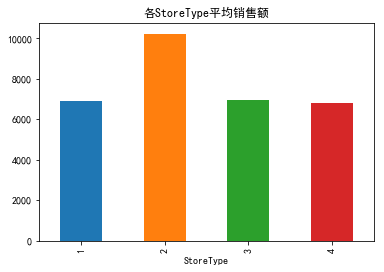

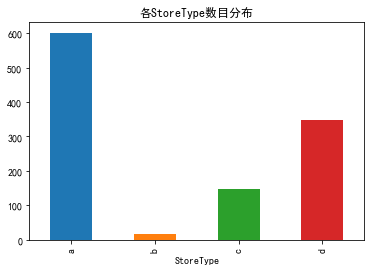

In [38]:

#不同的StoreType对最终销售额的影响
train_data[train_data['Sales']>0].groupby('StoreType').agg({'Sales':'mean'}).reset_index().plot(x='StoreType',y='Sales',kind='bar',legend=False,title='各StoreType平均销售额')
store_data.groupby('StoreType').agg({'Store':'count'}).reset_index().plot(x='StoreType',y='Store',kind='bar',legend=False,title='各StoreType数目分布')

b类型的商铺平均销量最高,但是数量很少，a类型的商铺更多

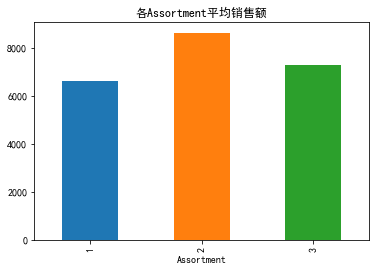

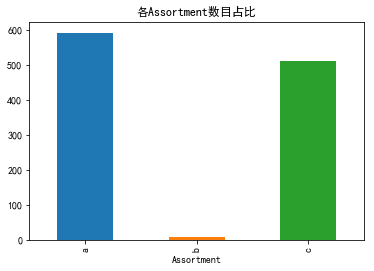

In [39]:
#不同的Assortment对最终销售额的影响
train_data[train_data['Sales']>0].groupby('Assortment').agg({'Sales':'mean'}).reset_index().plot(x='Assortment',y='Sales',kind='bar',legend=False,title='各Assortment平均销售额')
store_data.groupby('Assortment').agg({'Store':'count'}).reset_index().plot(x='Assortment',y='Store',kind='bar',legend=False,title='各Assortment数目占比')

b类型的Assortment销量最高，但是仍然数量最低，其他两个类型的店铺销量差不多。

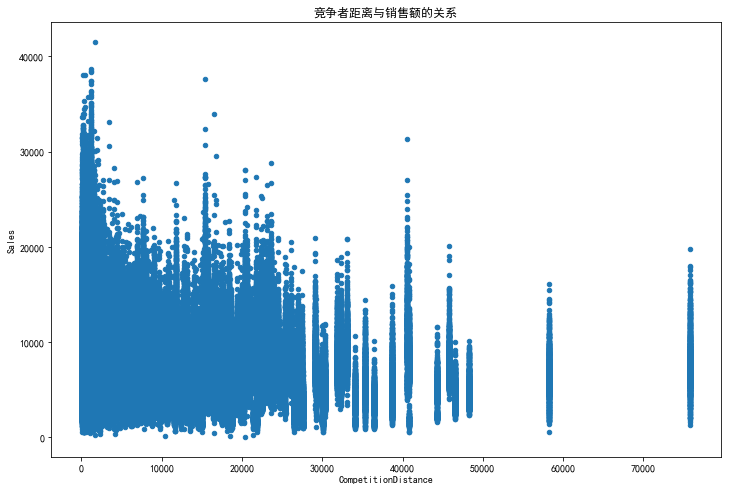

In [40]:
#观察CompetitionDistance特征对销量的影响
train_data[train_data['Sales']>0].plot(x='CompetitionDistance',y='Sales',kind='scatter',figsize=(12,8),title='竞争者距离与销售额的关系')

竞争者距离店铺近的情况更多，且两个店铺挨的比较近的话，反而会促进店铺的销售

In [41]:
#观察CompetitionOpenSinceYear特征对销量的影响

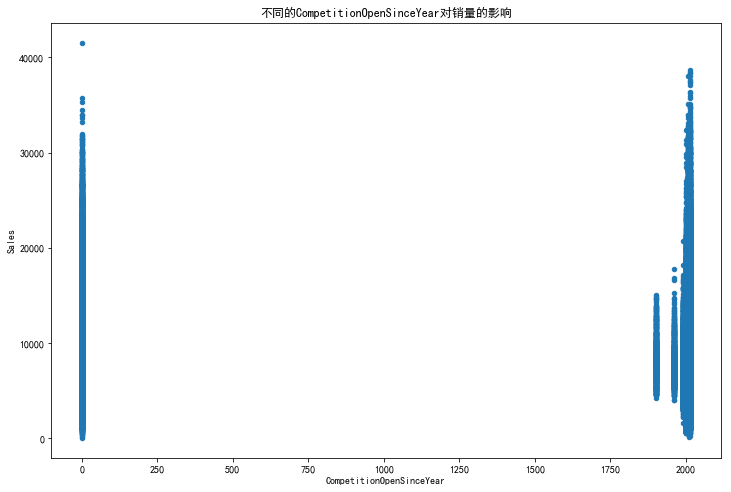

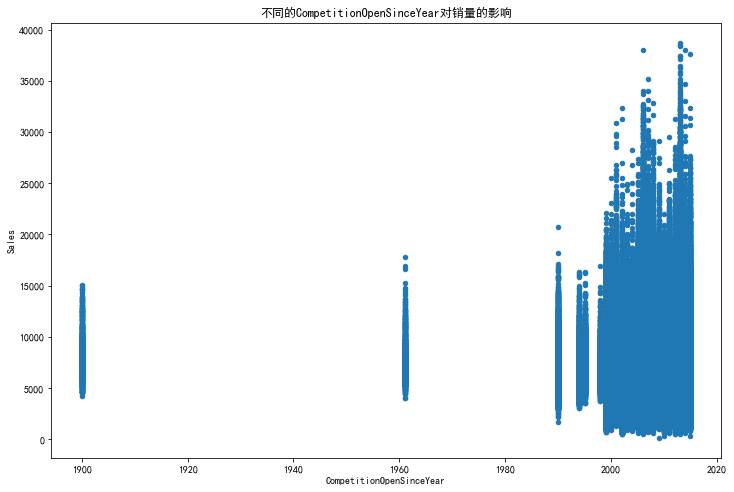

In [67]:
train_data[train_data['Sales']>0].plot(x='CompetitionOpenSinceYear',y='Sales',kind='scatter'
                                       ,figsize=(12,8),title='不同的CompetitionOpenSinceYear对销量的影响')
train_data[(train_data['Sales']>0)&(train_data['CompetitionOpenSinceYear']>0)].plot(x='CompetitionOpenSinceYear',y='Sales',kind='scatter'
                                       ,figsize=(12,8),title='不同的CompetitionOpenSinceYear对销量的影响')

几乎无法看到有用的信息，需要对这个信息进行处理，添加竞争者至今开业多少个月。

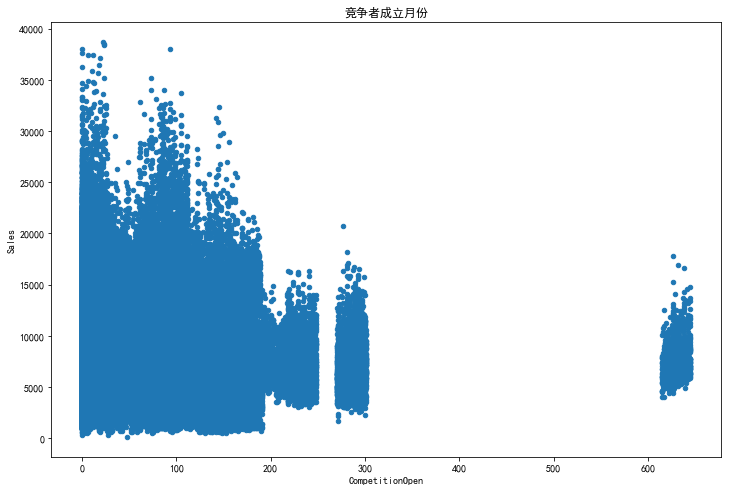

In [68]:
train_data[(train_data['CompetitionOpen']<1000)&(train_data['Sales']>0)].plot(x='CompetitionOpen',y='Sales',kind='scatter',figsize=(12,8),title='竞争者成立月份')

竞争者越早开张，则商店销售额越高，竞争者开业时间越长，则销售额的上限越低。

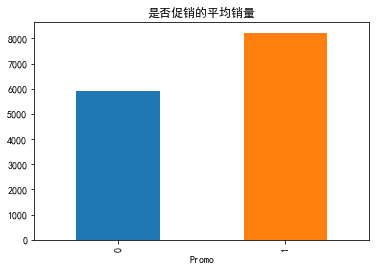

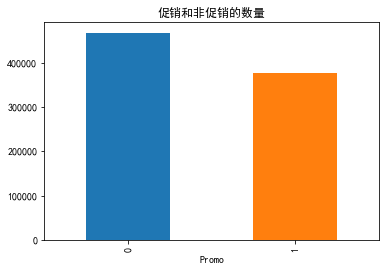

In [69]:
#观察Promo对销售的影响
train_data[train_data['Sales']>0].groupby('Promo').agg({'Sales':'mean'}).reset_index().plot(x='Promo',y='Sales',kind='bar',legend=False,title='是否促销的平均销量')
train_data[train_data['Sales']>0].groupby('Promo').agg({'Store':'count'}).reset_index().plot(x='Promo',y='Store',kind='bar',legend=False,title='促销和非促销的数量')

当天营业是否有促销，对该店铺的销售额还是有明显的影响的。

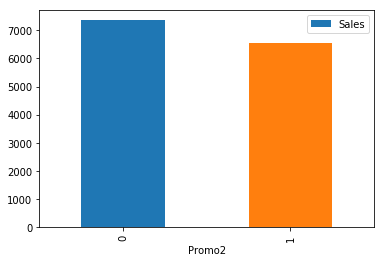

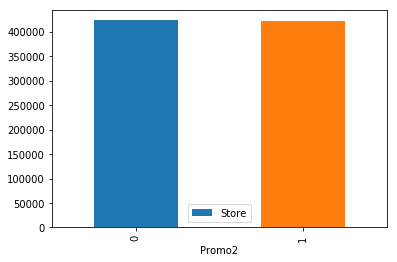

In [37]:
#观察Promo2对销售的影响
train_data[train_data['Sales']>0].groupby('Promo2').agg({'Sales':'mean'}).reset_index().plot(x='Promo2',y='Sales',kind='bar')
train_data[train_data['Sales']>0].groupby('Promo2').agg({'Store':'count'}).reset_index().plot(x='Promo2',y='Store',kind='bar')

从上表得知，有无促销对店铺的平均销售额影响有限。但是这有违常识，我需要继续验证一下这个结论。

同理，我们计算一下某一天是否处于促销期内，以及截止当日，促销持续了多久

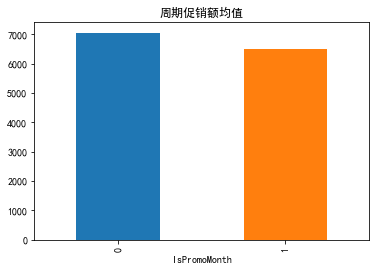

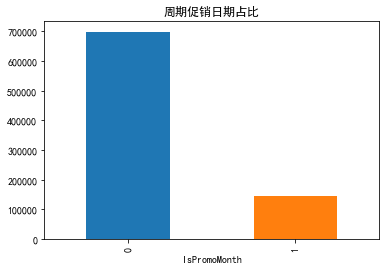

In [74]:
train_data[train_data['Sales']>0].groupby('IsPromoMonth').agg({'Sales':'mean'}).reset_index().plot(x='IsPromoMonth',y='Sales',kind='bar',legend=False,title='周期促销额均值')
train_data[train_data['Sales']>0].groupby('IsPromoMonth').agg({'Store':'count'}).reset_index().plot(x='IsPromoMonth',y='Store',kind='bar',legend=False,title='周期促销日期占比')

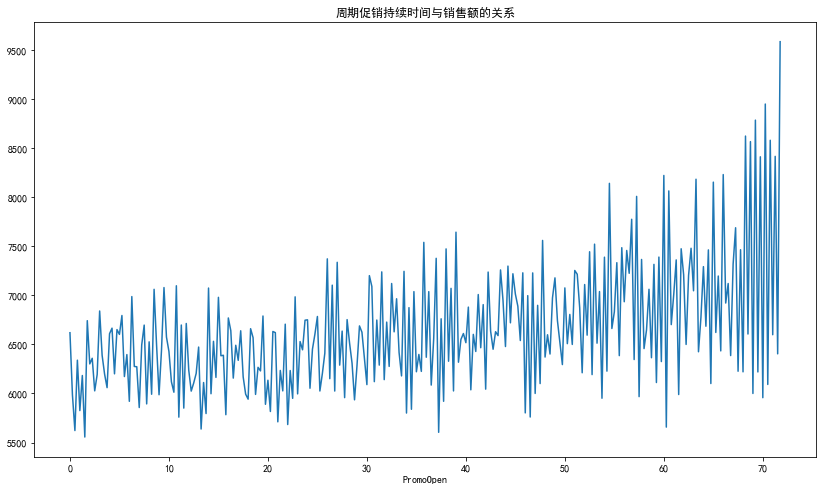

In [75]:
train_data[(train_data['Sales']>0)&(train_data['PromoOpen']<1000)].groupby('PromoOpen').agg({'Sales':'mean'}).reset_index().plot(x='PromoOpen',y='Sales',kind='line',figsize=(14,8),legend=False,title='周期促销持续时间与销售额的关系')

排除极大值后，促销开展期限与销量呈现一定相关性，促销越久，销量越高.

In [43]:
#观察一年中每日的平均销量

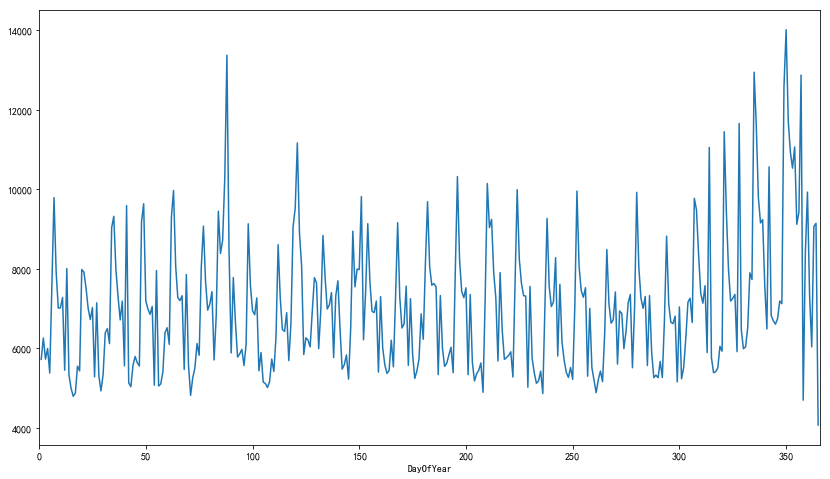

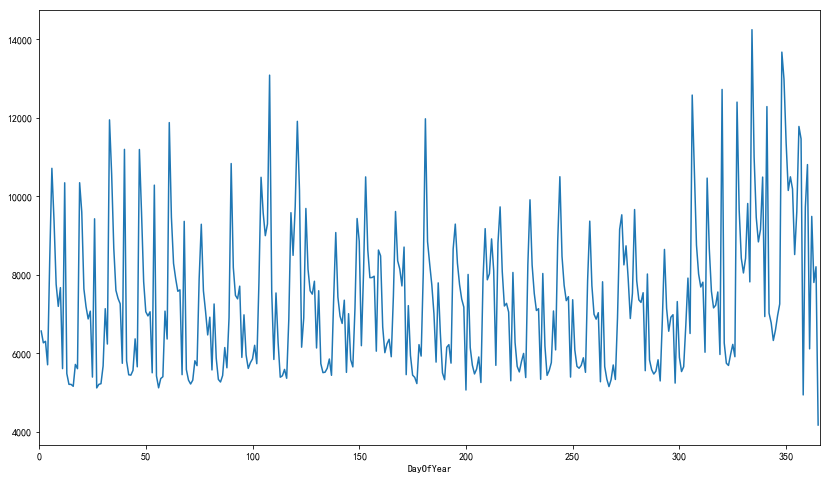

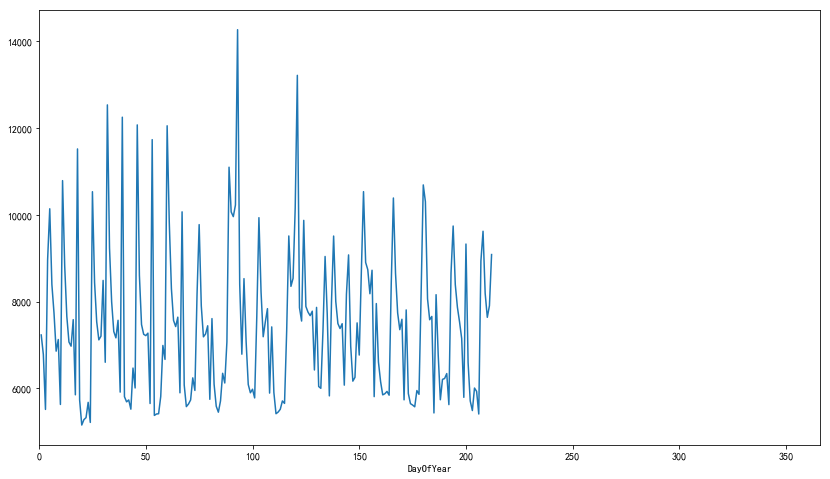

In [178]:
for key,grp in train_data[(train_data['Sales']>0)].groupby('Year'):
    grp.groupby('DayOfYear').agg({'Sales':'mean'}).reset_index().plot(x='DayOfYear',y='Sales',kind='line',figsize=(14,8),xlim=(0,366),legend=False)

看到销量和日期有一定想关性，每年的感恩节-圣诞假期附近是销售旺季，而第一季度末也会有以波销售上升期。夏天的销售额普遍较差。不同年之间销量差距不大

In [45]:
#观察国家假日的销量

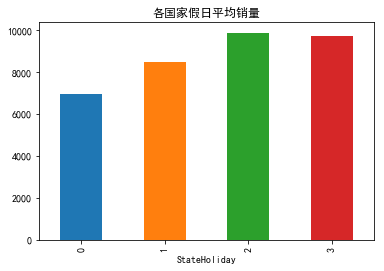

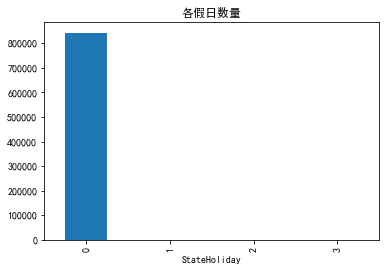

In [180]:
train_data[train_data['Sales']>0].groupby('StateHoliday').agg({'Sales':'mean'}).reset_index().plot(x='StateHoliday',y='Sales',kind='bar',legend=False,title='各国家假日平均销量')
train_data[train_data['Sales']>0].groupby('StateHoliday').agg({'Sales':'count'}).reset_index().plot(x='StateHoliday',y='Sales',kind='bar',legend=False,title='各假日数量')

国家节假日对销售额的影响非常明显，但是国家假日数量并不多

In [47]:
#观潮校园假日的效率

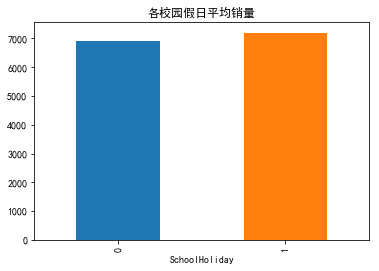

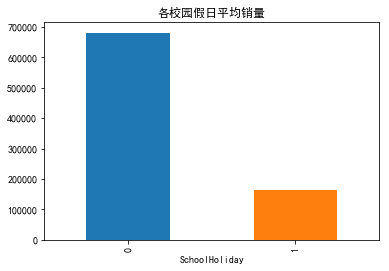

In [181]:
train_data[train_data['Sales']>0].groupby('SchoolHoliday').agg({'Sales':'mean'}).reset_index().plot(x='SchoolHoliday',y='Sales',kind='bar',legend=False,title='各校园假日平均销量')
train_data[train_data['Sales']>0].groupby('SchoolHoliday').agg({'Sales':'count'}).reset_index().plot(x='SchoolHoliday',y='Sales',kind='bar',legend=False,title='各校园假日平均销量')

学校假日对销售额的影响较小，但学校假日的数量要比国家假日多

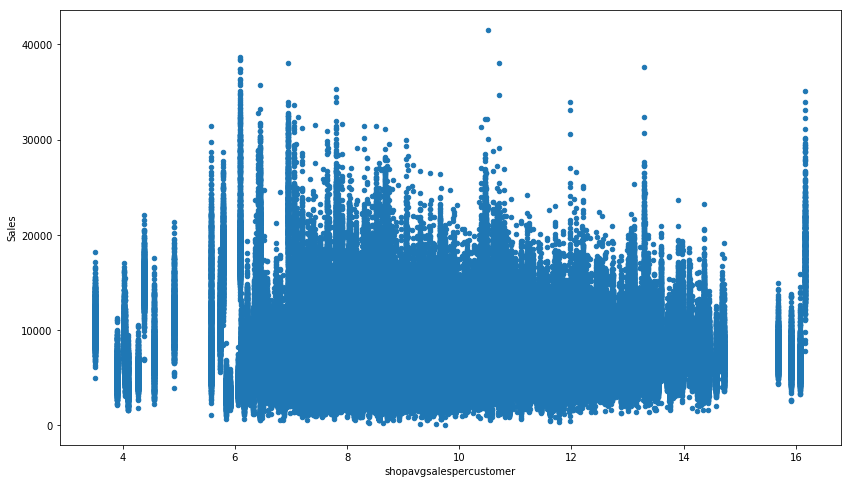

In [49]:
#观察shopavgsalespercustomer对销售额的影响
train_data[train_data['Sales']>0].plot(x='shopavgsalespercustomer',y='Sales',kind='scatter',figsize=(14,8))

似乎没有什么明显的特征

# 算法和技术
在这一部分，你需要讨论你解决问题时用到的算法和技术。你需要根据问题的特性和所属领域来论述使用这些方法的合理性。你需要考虑：

你所使用的算法，包括用到的变量/参数都清晰地说明了吗？
你是否已经详尽地描述并讨论了使用这些技术的合理性？
你是否清晰地描述了这些算法和技术具体会如何处理这些数据？

# 基准模型
在这一部分，你需要提供一个可以用于衡量解决方案性能的基准结果/阈值。这个基准模型要能够和你的解决方案的性能进行比较。你也应该讨论你为什么使用这个基准模型。一些需要考虑的问题：


你是否提供了作为基准的结果或数值，它们能够衡量模型的性能吗？
该基准是如何得到的（是靠数据还是假设）？

本次项目采用Kaggle指定的RMSPE作为评价指标

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow class="MJX-TeXAtom-ORD">
    <mtext>RMSPE</mtext>
  </mrow>
  <mo>=</mo>
  <msqrt>
    <mfrac>
      <mn>1</mn>
      <mi>n</mi>
    </mfrac>
    <munderover>
      <mo>&#x2211;<!-- ∑ --></mo>
      <mrow class="MJX-TeXAtom-ORD">
        <mi>i</mi>
        <mo>=</mo>
        <mn>1</mn>
      </mrow>
      <mrow class="MJX-TeXAtom-ORD">
        <mi>n</mi>
      </mrow>
    </munderover>
    <msup>
      <mrow>
        <mo>(</mo>
        <mfrac>
          <mrow>
            <msub>
              <mi>y</mi>
              <mi>i</mi>
            </msub>
            <mo>&#x2212;<!-- − --></mo>
            <msub>
              <mrow class="MJX-TeXAtom-ORD">
                <mover>
                  <mi>y</mi>
                  <mo stretchy="false">&#x005E;<!-- ^ --></mo>
                </mover>
              </mrow>
              <mi>i</mi>
            </msub>
          </mrow>
          <msub>
            <mi>y</mi>
            <mi>i</mi>
          </msub>
        </mfrac>
        <mo>)</mo>
      </mrow>
      <mn>2</mn>
    </msup>
  </msqrt>
  <mo>,</mo>
</math>

In [79]:
def rmspe(y,y_hat):
    return np.sqrt(np.mean((1-y_hat/y)**2))
def rmspe_xg(yhat, y):
    return rmspe(np.expm1(y), np.expm1(y_hat))

# 数据预处理
在这一部分， 你需要清晰记录你所有必要的数据预处理步骤。在前一个部分所描述的数据的异常或特性在这一部分需要被更正和处理。需要考虑的问题有：

如果你选择的算法需要进行特征选取或特征变换，你对此进行记录和描述了吗？
数据的探索这一部分中提及的异常和特性是否被更正了，对此进行记录和描述了吗？
如果你认为不需要进行预处理，你解释个中原因了吗？

In [174]:
#排除不营业的数据
train_data=train_data[(train_data['Open']==1)&(train_data['Sales']>0)]

In [81]:
#丢弃不需要的变量
drop_paramater=['Month','Week','Year','Date','Customers','Open','PromoInterval','monthStr']
train=train_data.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1)
test=test_data.drop(['Date','Open','PromoInterval','monthStr'],axis=1)

In [31]:
#进行One_Hot 编码
#我们计划对['StateHoliday','StoreType','Assortment']进行独热编码独
#热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设someFeature有三个可能的取值A，B或者C，。我们将把这个特征编码成someFeature_A, someFeature_B和someFeature_C.


In [46]:
# train=pd.get_dummies(train)


In [47]:
# test=pd.get_dummies(test)
# test=test.set_index('Id')
# test=test.reindex(columns=train.columns,fill_value=0)


In [33]:
# test.drop('Sales',axis=1,inplace=True)

将train数据集分为训练集和测试集


In [82]:
y_train=train['Sales']
X_train=train.drop('Sales',axis=1)

# 建立模型

In [83]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


In [34]:
# 用xgb.train 训练模型
# train_matrix = xgb.DMatrix(X_train, y_train)
# valid_matrix = xgb.DMatrix(X_val, y_val)
# watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

F:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [165]:
#设置参数
params_opt = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 66,
          }
num_round = 6000

In [195]:
# def train_model(params, num_round):
#     print('XGBoost Model Train Start....')
#     start_time = time.time()
#     model = xgb.train(params, train_matrix, num_round, evals=watchlist, 
#                       early_stopping_rounds=20, verbose_eval=True)
#     print('XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time))
#     return model

In [166]:
# model_opt = train_model(params_opt, num_round)

XGBoost Model Train Start....
[0]	train-rmse:6889.82	valid-rmse:6901.43
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:6240.08	valid-rmse:6252.2
[2]	train-rmse:5698.57	valid-rmse:5710.21
[3]	train-rmse:5163.67	valid-rmse:5174.64
[4]	train-rmse:4680.83	valid-rmse:4691.81
[5]	train-rmse:4276.88	valid-rmse:4286.42
[6]	train-rmse:3896.88	valid-rmse:3907
[7]	train-rmse:3542	valid-rmse:3552.48
[8]	train-rmse:3255.89	valid-rmse:3265.89
[9]	train-rmse:2978.34	valid-rmse:2988.58
[10]	train-rmse:2725.7	valid-rmse:2736.44
[11]	train-rmse:2527.07	valid-rmse:2538.16
[12]	train-rmse:2351.1	valid-rmse:2362.28
[13]	train-rmse:2194.78	valid-rmse:2207.08
[14]	train-rmse:2067.47	valid-rmse:2080.89
[15]	train-rmse:1917.28	valid-rmse:1931.72
[16]	train-rmse:1818.08	valid-rmse:1833.76
[17]	train-rmse:1727.15	valid-rmse:1743.11
[18]	train-rmse:1647.32	valid-rmse:1664.12
[19]	train-rmse:1576.64	val

[186]	train-rmse:647.422	valid-rmse:719.029
[187]	train-rmse:646.735	valid-rmse:718.579
[188]	train-rmse:646.446	valid-rmse:718.332
[189]	train-rmse:645.924	valid-rmse:717.997
[190]	train-rmse:645.458	valid-rmse:717.639
[191]	train-rmse:644.689	valid-rmse:716.911
[192]	train-rmse:643.596	valid-rmse:716.177
[193]	train-rmse:643.077	valid-rmse:715.785
[194]	train-rmse:642.539	valid-rmse:715.41
[195]	train-rmse:642.199	valid-rmse:715.13
[196]	train-rmse:641.275	valid-rmse:714.204
[197]	train-rmse:640.547	valid-rmse:713.638
[198]	train-rmse:639.828	valid-rmse:713.181
[199]	train-rmse:639.493	valid-rmse:712.976
[200]	train-rmse:638.609	valid-rmse:712.37
[201]	train-rmse:638.259	valid-rmse:712.151
[202]	train-rmse:637.594	valid-rmse:711.623
[203]	train-rmse:637.082	valid-rmse:711.302
[204]	train-rmse:636.624	valid-rmse:711.063
[205]	train-rmse:636.415	valid-rmse:710.906
[206]	train-rmse:635.943	valid-rmse:710.525
[207]	train-rmse:635.247	valid-rmse:710.08
[208]	train-rmse:634.792	valid-rmse:

[374]	train-rmse:558.668	valid-rmse:659.577
[375]	train-rmse:558.432	valid-rmse:659.487
[376]	train-rmse:558.039	valid-rmse:659.28
[377]	train-rmse:557.771	valid-rmse:659.178
[378]	train-rmse:557.535	valid-rmse:659.023
[379]	train-rmse:557.297	valid-rmse:658.887
[380]	train-rmse:557.126	valid-rmse:658.744
[381]	train-rmse:556.776	valid-rmse:658.568
[382]	train-rmse:556.267	valid-rmse:658.085
[383]	train-rmse:555.951	valid-rmse:657.917
[384]	train-rmse:555.689	valid-rmse:657.767
[385]	train-rmse:555.42	valid-rmse:657.676
[386]	train-rmse:555.227	valid-rmse:657.581
[387]	train-rmse:554.875	valid-rmse:657.355
[388]	train-rmse:554.598	valid-rmse:657.215
[389]	train-rmse:554.06	valid-rmse:656.961
[390]	train-rmse:553.97	valid-rmse:656.887
[391]	train-rmse:553.693	valid-rmse:656.775
[392]	train-rmse:553.409	valid-rmse:656.579
[393]	train-rmse:553.094	valid-rmse:656.442
[394]	train-rmse:552.727	valid-rmse:656.247
[395]	train-rmse:552.258	valid-rmse:655.943
[396]	train-rmse:551.808	valid-rmse:

[562]	train-rmse:505.831	valid-rmse:631.938
[563]	train-rmse:505.627	valid-rmse:631.883
[564]	train-rmse:505.37	valid-rmse:631.737
[565]	train-rmse:505.187	valid-rmse:631.668
[566]	train-rmse:505.089	valid-rmse:631.637
[567]	train-rmse:504.812	valid-rmse:631.517
[568]	train-rmse:504.536	valid-rmse:631.376
[569]	train-rmse:504.409	valid-rmse:631.3
[570]	train-rmse:504.197	valid-rmse:631.199
[571]	train-rmse:503.98	valid-rmse:631.197
[572]	train-rmse:503.716	valid-rmse:630.961
[573]	train-rmse:503.422	valid-rmse:630.683
[574]	train-rmse:503.182	valid-rmse:630.439
[575]	train-rmse:503.061	valid-rmse:630.367
[576]	train-rmse:502.7	valid-rmse:630.018
[577]	train-rmse:502.557	valid-rmse:629.938
[578]	train-rmse:502.349	valid-rmse:629.813
[579]	train-rmse:502.218	valid-rmse:629.762
[580]	train-rmse:502.013	valid-rmse:629.669
[581]	train-rmse:501.863	valid-rmse:629.602
[582]	train-rmse:501.654	valid-rmse:629.509
[583]	train-rmse:501.408	valid-rmse:629.404
[584]	train-rmse:501.265	valid-rmse:62

[750]	train-rmse:469.469	valid-rmse:617.069
[751]	train-rmse:469.176	valid-rmse:616.893
[752]	train-rmse:469.062	valid-rmse:616.846
[753]	train-rmse:468.914	valid-rmse:616.793
[754]	train-rmse:468.807	valid-rmse:616.77
[755]	train-rmse:468.566	valid-rmse:616.616
[756]	train-rmse:468.335	valid-rmse:616.504
[757]	train-rmse:468.242	valid-rmse:616.488
[758]	train-rmse:468.109	valid-rmse:616.448
[759]	train-rmse:467.924	valid-rmse:616.454
[760]	train-rmse:467.806	valid-rmse:616.387
[761]	train-rmse:467.69	valid-rmse:616.324
[762]	train-rmse:467.555	valid-rmse:616.264
[763]	train-rmse:467.334	valid-rmse:616.237
[764]	train-rmse:467.182	valid-rmse:616.151
[765]	train-rmse:467.04	valid-rmse:616.089
[766]	train-rmse:466.949	valid-rmse:616.085
[767]	train-rmse:466.815	valid-rmse:616.047
[768]	train-rmse:466.705	valid-rmse:615.982
[769]	train-rmse:466.493	valid-rmse:615.958
[770]	train-rmse:466.315	valid-rmse:615.91
[771]	train-rmse:466.115	valid-rmse:615.814
[772]	train-rmse:465.872	valid-rmse:

[938]	train-rmse:440.536	valid-rmse:608.059
[939]	train-rmse:440.386	valid-rmse:608.029
[940]	train-rmse:440.182	valid-rmse:607.954
[941]	train-rmse:440.068	valid-rmse:607.914
[942]	train-rmse:439.94	valid-rmse:607.877
[943]	train-rmse:439.832	valid-rmse:607.845
[944]	train-rmse:439.661	valid-rmse:607.83
[945]	train-rmse:439.481	valid-rmse:607.824
[946]	train-rmse:439.318	valid-rmse:607.775
[947]	train-rmse:439.153	valid-rmse:607.723
[948]	train-rmse:439.103	valid-rmse:607.706
[949]	train-rmse:439.083	valid-rmse:607.69
[950]	train-rmse:438.973	valid-rmse:607.665
[951]	train-rmse:438.845	valid-rmse:607.636
[952]	train-rmse:438.657	valid-rmse:607.586
[953]	train-rmse:438.508	valid-rmse:607.53
[954]	train-rmse:438.417	valid-rmse:607.507
[955]	train-rmse:438.279	valid-rmse:607.473
[956]	train-rmse:438.158	valid-rmse:607.453
[957]	train-rmse:438.055	valid-rmse:607.396
[958]	train-rmse:437.931	valid-rmse:607.4
[959]	train-rmse:437.781	valid-rmse:607.336
[960]	train-rmse:437.62	valid-rmse:607

[1123]	train-rmse:417.05	valid-rmse:602.023
[1124]	train-rmse:416.958	valid-rmse:601.993
[1125]	train-rmse:416.771	valid-rmse:601.96
[1126]	train-rmse:416.693	valid-rmse:601.849
[1127]	train-rmse:416.593	valid-rmse:601.827
[1128]	train-rmse:416.464	valid-rmse:601.794
[1129]	train-rmse:416.378	valid-rmse:601.767
[1130]	train-rmse:416.334	valid-rmse:601.768
[1131]	train-rmse:416.186	valid-rmse:601.74
[1132]	train-rmse:416.106	valid-rmse:601.723
[1133]	train-rmse:416.055	valid-rmse:601.687
[1134]	train-rmse:416.015	valid-rmse:601.685
[1135]	train-rmse:415.847	valid-rmse:601.632
[1136]	train-rmse:415.769	valid-rmse:601.616
[1137]	train-rmse:415.682	valid-rmse:601.596
[1138]	train-rmse:415.551	valid-rmse:601.557
[1139]	train-rmse:415.47	valid-rmse:601.561
[1140]	train-rmse:415.345	valid-rmse:601.562
[1141]	train-rmse:415.169	valid-rmse:601.528
[1142]	train-rmse:415.062	valid-rmse:601.515
[1143]	train-rmse:414.946	valid-rmse:601.507
[1144]	train-rmse:414.815	valid-rmse:601.491
[1145]	train-r

[1306]	train-rmse:397.799	valid-rmse:598.209
[1307]	train-rmse:397.731	valid-rmse:598.203
[1308]	train-rmse:397.656	valid-rmse:598.201
[1309]	train-rmse:397.533	valid-rmse:598.162
[1310]	train-rmse:397.42	valid-rmse:598.152
[1311]	train-rmse:397.315	valid-rmse:598.132
[1312]	train-rmse:397.218	valid-rmse:598.116
[1313]	train-rmse:397.157	valid-rmse:598.113
[1314]	train-rmse:397.003	valid-rmse:598.077
[1315]	train-rmse:396.927	valid-rmse:598.055
[1316]	train-rmse:396.805	valid-rmse:598.044
[1317]	train-rmse:396.664	valid-rmse:598.002
[1318]	train-rmse:396.597	valid-rmse:597.955
[1319]	train-rmse:396.497	valid-rmse:597.945
[1320]	train-rmse:396.374	valid-rmse:597.939
[1321]	train-rmse:396.339	valid-rmse:597.929
[1322]	train-rmse:396.257	valid-rmse:597.916
[1323]	train-rmse:396.198	valid-rmse:597.927
[1324]	train-rmse:396.103	valid-rmse:597.9
[1325]	train-rmse:396.07	valid-rmse:597.901
[1326]	train-rmse:395.926	valid-rmse:597.889
[1327]	train-rmse:395.812	valid-rmse:597.863
[1328]	train-r

[1489]	train-rmse:380.14	valid-rmse:595.407
[1490]	train-rmse:380.05	valid-rmse:595.388
[1491]	train-rmse:379.948	valid-rmse:595.331
[1492]	train-rmse:379.886	valid-rmse:595.311
[1493]	train-rmse:379.753	valid-rmse:595.296
[1494]	train-rmse:379.697	valid-rmse:595.268
[1495]	train-rmse:379.631	valid-rmse:595.237
[1496]	train-rmse:379.543	valid-rmse:595.23
[1497]	train-rmse:379.43	valid-rmse:595.228
[1498]	train-rmse:379.311	valid-rmse:595.22
[1499]	train-rmse:379.247	valid-rmse:595.208
[1500]	train-rmse:379.093	valid-rmse:595.189
[1501]	train-rmse:378.987	valid-rmse:595.148
[1502]	train-rmse:378.868	valid-rmse:595.121
[1503]	train-rmse:378.724	valid-rmse:595.126
[1504]	train-rmse:378.645	valid-rmse:595.119
[1505]	train-rmse:378.58	valid-rmse:595.099
[1506]	train-rmse:378.527	valid-rmse:595.094
[1507]	train-rmse:378.428	valid-rmse:595.091
[1508]	train-rmse:378.343	valid-rmse:595.063
[1509]	train-rmse:378.232	valid-rmse:595.049
[1510]	train-rmse:378.136	valid-rmse:595.054
[1511]	train-rms

In [170]:
# def predict(model, X_val, y_val):
#     print('XGBoost Model Valid Start....')
#     start_time = time.time()
#     pred_valid = model.predict(xgb.DMatrix(X_val))
#     rmspe_value = rmspe(y_val, pred_valid)
#     print('Valid RMSPE:'+str(rmspe_value))
#     print('XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time))
#     return pred_valid, rmspe_value

In [171]:
# pred_valid_opt, rmspe_opt = predict(model_opt, X_val, y_val)

XGBoost Model Valid Start....
Valid RMSPE:0.11785026135483434
XGBoost Model Valid End, Time: 5.344712 s....


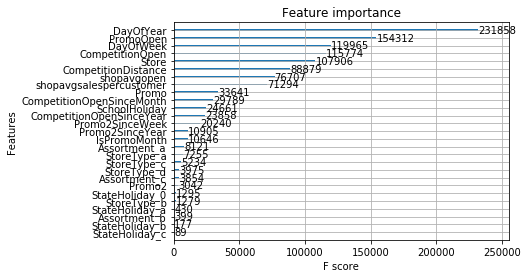

In [172]:
# xgb.plot_importance(model_opt)

In [261]:
# dtest = xgb.DMatrix(test, feature_names=list(test))

In [262]:
# test_pred=model_opt.predict(dtest)

In [264]:
# test_excel=pd.read_csv('C:/Users/Darren.wang/Desktop/rossmann-store-sales/sample_submission.csv')

In [266]:
# test_excel['Sales']=test_pred

In [268]:
# writer=pd.ExcelWriter('C:/Users/Darren.wang/Desktop/rossmann-store-sales/sample_submission.xlsx')
# test_excel.to_excel(writer,sheet_name='sample_submission')
# writer.save()

# 训练最优模型

#用gridsearchCV调参
#由于训练效果不理想，因此注释掉

In [47]:
# def train_model(params, num_round):
#     print('XGBoost Model Train Start....')
#     start_time = time.time()
#     model = xgb.train(params, train_matrix, num_round, evals=watchlist, 
#                       early_stopping_rounds=20,  verbose_eval=True)
#     print('XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time))
#     return model
# def predict(model, X_val, y_val):
#     print('XGBoost Model Valid Start....')
#     start_time = time.time()
#     pred_valid = model.predict(xgb.DMatrix(X_val))
#     rmspe_value = rmspe(y_val, pred_valid)
#     print('Valid RMSPE:'+str(rmspe_value))
#     print('XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time))
#     return pred_valid, rmspe_value
# def try_parameter(para,num_round,X_val,y_val):
#     global model_opt
#     model_opt = train_model(params_opt, num_round)

#     pred_valid_opt, rmspe_opt = predict(model_opt, X_val, y_val)
#     dtest = xgb.DMatrix(test, feature_names=list(test))
#     test_pred=model_opt.predict(dtest)
#     test_excel=pd.read_csv('C:/Users/Darren.wang/Desktop/rossmann-store-sales/sample_submission.csv')
#     test_excel['Sales']=test_pred
#     writer=pd.ExcelWriter('C:/Users/Darren.wang/Desktop/rossmann-store-sales/sample_submission.xlsx')
#     test_excel.to_excel(writer,sheet_name='sample_submission')
#     writer.save()

In [160]:
#为了保证日期的连续性，尝试不随机分训练集。但是效果不好，注释掉。
# X_train,X_val=X_train.iloc[:-50000,:],X_train.iloc[-50000:,:]
# y_train,y_val=y_train[:-50000],y_train[-50000:]

In [85]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)


In [86]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [105]:

xgboost_tree = xgb.XGBRegressor(
#    n_jobs = -1,
    n_estimators = 6000,
    eta = 0.03,
    max_depth = 12,
#    min_child_weight = 9,
    subsample = 0.9,
    colsample_bytree = 0.9,
    silent = 0,
#    gamma=.7,
    random_state = 66,
    booster='gbtree',
#    reg_lambda=15,
    tree_method= 'gpu_hist',
    objective="reg:linear"
)
xgboost_tree.fit(X_train, np.log1p(y_train), 
                 eval_set = [(X_train, np.log1p(y_train)), (X_val, np.log1p(y_val))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 100
                )

[23:50:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.44225	validation_1-rmse:7.4422	validation_0-rmspe:0.999532	validation_1-rmspe:0.999531
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 100 rounds.
[1]	validation_0-rmse:6.69889	validation_1-rmse:6.69887	validation_0-rmspe:0.998838	validation_1-rmspe:0.998838
[2]	validation_0-rmse:6.02965	validation_1-rmse:6.02968	validation_0-rmspe:0.997593	validation_1-rmspe:0.997592
[3]	validation_0-rmse:5.42749	validation_1-rmse:5.42757	validation_0-rmspe:0.995496	validation_1-rmspe:0.995495
[4]	validation_0-rmse:4.88553	validation_1-rmse:4.88566	validation_0-rmspe:0.992188	validation_1-rmspe:0.992185
[5]	validation_0-rmse:4.39779	validation_1-rmse:4.39798	validation_0-rmspe:0.987247	validation_1-rmspe:0.987244
[6]

[70]	validation_0-rmse:0.103017	validation_1-rmse:0.110754	validation_0-rmspe:0.121189	validation_1-rmspe:0.137607
[71]	validation_0-rmse:0.101993	validation_1-rmse:0.109815	validation_0-rmspe:0.120202	validation_1-rmspe:0.136777
[72]	validation_0-rmse:0.101577	validation_1-rmse:0.109481	validation_0-rmspe:0.119866	validation_1-rmspe:0.136375
[73]	validation_0-rmse:0.101295	validation_1-rmse:0.109303	validation_0-rmspe:0.119557	validation_1-rmspe:0.13635
[74]	validation_0-rmse:0.100688	validation_1-rmse:0.108868	validation_0-rmspe:0.118639	validation_1-rmspe:0.136034
[75]	validation_0-rmse:0.100342	validation_1-rmse:0.108664	validation_0-rmspe:0.118318	validation_1-rmspe:0.135802
[76]	validation_0-rmse:0.099808	validation_1-rmse:0.108246	validation_0-rmspe:0.117809	validation_1-rmspe:0.135336
[77]	validation_0-rmse:0.099321	validation_1-rmse:0.107904	validation_0-rmspe:0.117357	validation_1-rmspe:0.135086
[78]	validation_0-rmse:0.09906	validation_1-rmse:0.107739	validation_0-rmspe:0.11

[142]	validation_0-rmse:0.083037	validation_1-rmse:0.096401	validation_0-rmspe:0.093795	validation_1-rmspe:0.121899
[143]	validation_0-rmse:0.08285	validation_1-rmse:0.096293	validation_0-rmspe:0.092169	validation_1-rmspe:0.121845
[144]	validation_0-rmse:0.082591	validation_1-rmse:0.096074	validation_0-rmspe:0.091913	validation_1-rmspe:0.121406
[145]	validation_0-rmse:0.082316	validation_1-rmse:0.095863	validation_0-rmspe:0.091641	validation_1-rmspe:0.121214
[146]	validation_0-rmse:0.082154	validation_1-rmse:0.095792	validation_0-rmspe:0.091452	validation_1-rmspe:0.121098
[147]	validation_0-rmse:0.082058	validation_1-rmse:0.095734	validation_0-rmspe:0.09136	validation_1-rmspe:0.121056
[148]	validation_0-rmse:0.081862	validation_1-rmse:0.095635	validation_0-rmspe:0.091127	validation_1-rmspe:0.12098
[149]	validation_0-rmse:0.081699	validation_1-rmse:0.095515	validation_0-rmspe:0.090963	validation_1-rmspe:0.120856
[150]	validation_0-rmse:0.081539	validation_1-rmse:0.095429	validation_0-rm

[213]	validation_0-rmse:0.073513	validation_1-rmse:0.091175	validation_0-rmspe:0.078347	validation_1-rmspe:0.116229
[214]	validation_0-rmse:0.073438	validation_1-rmse:0.09115	validation_0-rmspe:0.078265	validation_1-rmspe:0.116213
[215]	validation_0-rmse:0.073359	validation_1-rmse:0.091118	validation_0-rmspe:0.078173	validation_1-rmspe:0.115959
[216]	validation_0-rmse:0.073275	validation_1-rmse:0.091076	validation_0-rmspe:0.078087	validation_1-rmspe:0.115821
[217]	validation_0-rmse:0.073159	validation_1-rmse:0.091029	validation_0-rmspe:0.077919	validation_1-rmspe:0.115781
[218]	validation_0-rmse:0.073007	validation_1-rmse:0.090946	validation_0-rmspe:0.07774	validation_1-rmspe:0.115651
[219]	validation_0-rmse:0.072894	validation_1-rmse:0.090897	validation_0-rmspe:0.077605	validation_1-rmspe:0.1156
[220]	validation_0-rmse:0.072768	validation_1-rmse:0.090844	validation_0-rmspe:0.077479	validation_1-rmspe:0.115563
[221]	validation_0-rmse:0.072677	validation_1-rmse:0.090817	validation_0-rms

[284]	validation_0-rmse:0.067176	validation_1-rmse:0.088765	validation_0-rmspe:0.070502	validation_1-rmspe:0.113594
[285]	validation_0-rmse:0.067078	validation_1-rmse:0.088735	validation_0-rmspe:0.070403	validation_1-rmspe:0.113571
[286]	validation_0-rmse:0.067022	validation_1-rmse:0.088724	validation_0-rmspe:0.070339	validation_1-rmspe:0.11359
[287]	validation_0-rmse:0.066955	validation_1-rmse:0.088704	validation_0-rmspe:0.070271	validation_1-rmspe:0.113578
[288]	validation_0-rmse:0.066904	validation_1-rmse:0.088685	validation_0-rmspe:0.070201	validation_1-rmspe:0.113549
[289]	validation_0-rmse:0.066835	validation_1-rmse:0.08866	validation_0-rmspe:0.070127	validation_1-rmspe:0.113536
[290]	validation_0-rmse:0.066758	validation_1-rmse:0.088632	validation_0-rmspe:0.070019	validation_1-rmspe:0.11352
[291]	validation_0-rmse:0.06668	validation_1-rmse:0.088625	validation_0-rmspe:0.069932	validation_1-rmspe:0.113514
[292]	validation_0-rmse:0.066583	validation_1-rmse:0.088591	validation_0-rms

[355]	validation_0-rmse:0.062483	validation_1-rmse:0.087572	validation_0-rmspe:0.064796	validation_1-rmspe:0.111983
[356]	validation_0-rmse:0.062422	validation_1-rmse:0.087559	validation_0-rmspe:0.064734	validation_1-rmspe:0.111961
[357]	validation_0-rmse:0.062375	validation_1-rmse:0.087549	validation_0-rmspe:0.064676	validation_1-rmspe:0.111955
[358]	validation_0-rmse:0.062302	validation_1-rmse:0.087525	validation_0-rmspe:0.064575	validation_1-rmspe:0.111905
[359]	validation_0-rmse:0.062241	validation_1-rmse:0.087514	validation_0-rmspe:0.064504	validation_1-rmspe:0.111909
[360]	validation_0-rmse:0.062204	validation_1-rmse:0.087504	validation_0-rmspe:0.064464	validation_1-rmspe:0.111882
[361]	validation_0-rmse:0.062167	validation_1-rmse:0.087502	validation_0-rmspe:0.064426	validation_1-rmspe:0.11188
[362]	validation_0-rmse:0.062111	validation_1-rmse:0.087495	validation_0-rmspe:0.064368	validation_1-rmspe:0.111852
[363]	validation_0-rmse:0.06207	validation_1-rmse:0.087487	validation_0-r

[426]	validation_0-rmse:0.058683	validation_1-rmse:0.086778	validation_0-rmspe:0.060382	validation_1-rmspe:0.111158
[427]	validation_0-rmse:0.058624	validation_1-rmse:0.086773	validation_0-rmspe:0.060313	validation_1-rmspe:0.111156
[428]	validation_0-rmse:0.058576	validation_1-rmse:0.086766	validation_0-rmspe:0.060262	validation_1-rmspe:0.111143
[429]	validation_0-rmse:0.058539	validation_1-rmse:0.086761	validation_0-rmspe:0.060224	validation_1-rmspe:0.111139
[430]	validation_0-rmse:0.058497	validation_1-rmse:0.086752	validation_0-rmspe:0.060181	validation_1-rmspe:0.111134
[431]	validation_0-rmse:0.058436	validation_1-rmse:0.086747	validation_0-rmspe:0.06009	validation_1-rmspe:0.111128
[432]	validation_0-rmse:0.058403	validation_1-rmse:0.086742	validation_0-rmspe:0.060056	validation_1-rmspe:0.111116
[433]	validation_0-rmse:0.058368	validation_1-rmse:0.086742	validation_0-rmspe:0.060012	validation_1-rmspe:0.111118
[434]	validation_0-rmse:0.058324	validation_1-rmse:0.086737	validation_0-

[497]	validation_0-rmse:0.055519	validation_1-rmse:0.086319	validation_0-rmspe:0.056854	validation_1-rmspe:0.110608
[498]	validation_0-rmse:0.055494	validation_1-rmse:0.086318	validation_0-rmspe:0.056828	validation_1-rmspe:0.110614
[499]	validation_0-rmse:0.055431	validation_1-rmse:0.086312	validation_0-rmspe:0.056749	validation_1-rmspe:0.110613
[500]	validation_0-rmse:0.055377	validation_1-rmse:0.086309	validation_0-rmspe:0.056685	validation_1-rmspe:0.110613
[501]	validation_0-rmse:0.055338	validation_1-rmse:0.086305	validation_0-rmspe:0.056643	validation_1-rmspe:0.110608
[502]	validation_0-rmse:0.055277	validation_1-rmse:0.086295	validation_0-rmspe:0.05657	validation_1-rmspe:0.110586
[503]	validation_0-rmse:0.055236	validation_1-rmse:0.086292	validation_0-rmspe:0.056525	validation_1-rmspe:0.110573
[504]	validation_0-rmse:0.055203	validation_1-rmse:0.086284	validation_0-rmspe:0.05649	validation_1-rmspe:0.110569
[505]	validation_0-rmse:0.05517	validation_1-rmse:0.086283	validation_0-rm

[568]	validation_0-rmse:0.052643	validation_1-rmse:0.08605	validation_0-rmspe:0.053655	validation_1-rmspe:0.110155
[569]	validation_0-rmse:0.05261	validation_1-rmse:0.086047	validation_0-rmspe:0.053621	validation_1-rmspe:0.110152
[570]	validation_0-rmse:0.052584	validation_1-rmse:0.08605	validation_0-rmspe:0.053595	validation_1-rmspe:0.110153
[571]	validation_0-rmse:0.052555	validation_1-rmse:0.086046	validation_0-rmspe:0.053565	validation_1-rmspe:0.110129
[572]	validation_0-rmse:0.052516	validation_1-rmse:0.086046	validation_0-rmspe:0.053521	validation_1-rmspe:0.110136
[573]	validation_0-rmse:0.05248	validation_1-rmse:0.086046	validation_0-rmspe:0.053484	validation_1-rmspe:0.110135
[574]	validation_0-rmse:0.052441	validation_1-rmse:0.086039	validation_0-rmspe:0.053444	validation_1-rmspe:0.11013
[575]	validation_0-rmse:0.052403	validation_1-rmse:0.086031	validation_0-rmspe:0.053406	validation_1-rmspe:0.110117
[576]	validation_0-rmse:0.052367	validation_1-rmse:0.086026	validation_0-rmsp

[639]	validation_0-rmse:0.050124	validation_1-rmse:0.085905	validation_0-rmspe:0.050937	validation_1-rmspe:0.10999
[640]	validation_0-rmse:0.050086	validation_1-rmse:0.085903	validation_0-rmspe:0.050895	validation_1-rmspe:0.109986
[641]	validation_0-rmse:0.050053	validation_1-rmse:0.085902	validation_0-rmspe:0.050859	validation_1-rmspe:0.109966
[642]	validation_0-rmse:0.050024	validation_1-rmse:0.085898	validation_0-rmspe:0.050829	validation_1-rmspe:0.109955
[643]	validation_0-rmse:0.049979	validation_1-rmse:0.085897	validation_0-rmspe:0.05078	validation_1-rmspe:0.10996
[644]	validation_0-rmse:0.049944	validation_1-rmse:0.085898	validation_0-rmspe:0.050743	validation_1-rmspe:0.109956
[645]	validation_0-rmse:0.049912	validation_1-rmse:0.085902	validation_0-rmspe:0.050709	validation_1-rmspe:0.10996
[646]	validation_0-rmse:0.049869	validation_1-rmse:0.0859	validation_0-rmspe:0.050664	validation_1-rmspe:0.109952
[647]	validation_0-rmse:0.049836	validation_1-rmse:0.0859	validation_0-rmspe:0

[710]	validation_0-rmse:0.047856	validation_1-rmse:0.085817	validation_0-rmspe:0.048531	validation_1-rmspe:0.109815
[711]	validation_0-rmse:0.047825	validation_1-rmse:0.085819	validation_0-rmspe:0.048494	validation_1-rmspe:0.109815
[712]	validation_0-rmse:0.047786	validation_1-rmse:0.085817	validation_0-rmspe:0.048454	validation_1-rmspe:0.109816
[713]	validation_0-rmse:0.047757	validation_1-rmse:0.085812	validation_0-rmspe:0.048424	validation_1-rmspe:0.109819
[714]	validation_0-rmse:0.047719	validation_1-rmse:0.085808	validation_0-rmspe:0.048385	validation_1-rmspe:0.109813
[715]	validation_0-rmse:0.047695	validation_1-rmse:0.085809	validation_0-rmspe:0.04836	validation_1-rmspe:0.109806
[716]	validation_0-rmse:0.047669	validation_1-rmse:0.085808	validation_0-rmspe:0.048333	validation_1-rmspe:0.109808
[717]	validation_0-rmse:0.047629	validation_1-rmse:0.085805	validation_0-rmspe:0.048287	validation_1-rmspe:0.109804
[718]	validation_0-rmse:0.047584	validation_1-rmse:0.085801	validation_0-

[781]	validation_0-rmse:0.045685	validation_1-rmse:0.085786	validation_0-rmspe:0.046202	validation_1-rmspe:0.109503
[782]	validation_0-rmse:0.045653	validation_1-rmse:0.085788	validation_0-rmspe:0.046169	validation_1-rmspe:0.109507
[783]	validation_0-rmse:0.045629	validation_1-rmse:0.085787	validation_0-rmspe:0.046145	validation_1-rmspe:0.109503
[784]	validation_0-rmse:0.045602	validation_1-rmse:0.085787	validation_0-rmspe:0.046117	validation_1-rmspe:0.109501
[785]	validation_0-rmse:0.045574	validation_1-rmse:0.085787	validation_0-rmspe:0.046088	validation_1-rmspe:0.109505
[786]	validation_0-rmse:0.045556	validation_1-rmse:0.08579	validation_0-rmspe:0.04607	validation_1-rmspe:0.109507
[787]	validation_0-rmse:0.045527	validation_1-rmse:0.08579	validation_0-rmspe:0.046041	validation_1-rmspe:0.109514
[788]	validation_0-rmse:0.045493	validation_1-rmse:0.085788	validation_0-rmspe:0.046005	validation_1-rmspe:0.10952
[789]	validation_0-rmse:0.045479	validation_1-rmse:0.08579	validation_0-rmsp

[852]	validation_0-rmse:0.043854	validation_1-rmse:0.085774	validation_0-rmspe:0.0443	validation_1-rmspe:0.109276
[853]	validation_0-rmse:0.043819	validation_1-rmse:0.085774	validation_0-rmspe:0.044264	validation_1-rmspe:0.109275
[854]	validation_0-rmse:0.043793	validation_1-rmse:0.085775	validation_0-rmspe:0.044235	validation_1-rmspe:0.109274
[855]	validation_0-rmse:0.043755	validation_1-rmse:0.085774	validation_0-rmspe:0.044197	validation_1-rmspe:0.109278
[856]	validation_0-rmse:0.043737	validation_1-rmse:0.085774	validation_0-rmspe:0.044178	validation_1-rmspe:0.109278
[857]	validation_0-rmse:0.043703	validation_1-rmse:0.085774	validation_0-rmspe:0.044142	validation_1-rmspe:0.109282
[858]	validation_0-rmse:0.043681	validation_1-rmse:0.085775	validation_0-rmspe:0.044119	validation_1-rmspe:0.109284
[859]	validation_0-rmse:0.043653	validation_1-rmse:0.085777	validation_0-rmspe:0.044089	validation_1-rmspe:0.109287
[860]	validation_0-rmse:0.043622	validation_1-rmse:0.085775	validation_0-r

[923]	validation_0-rmse:0.042019	validation_1-rmse:0.085812	validation_0-rmspe:0.04238	validation_1-rmspe:0.10927
[924]	validation_0-rmse:0.041991	validation_1-rmse:0.085814	validation_0-rmspe:0.04235	validation_1-rmspe:0.109278
[925]	validation_0-rmse:0.041963	validation_1-rmse:0.085813	validation_0-rmspe:0.042321	validation_1-rmspe:0.109277
[926]	validation_0-rmse:0.041943	validation_1-rmse:0.085815	validation_0-rmspe:0.042301	validation_1-rmspe:0.109285
[927]	validation_0-rmse:0.041921	validation_1-rmse:0.085815	validation_0-rmspe:0.042279	validation_1-rmspe:0.109285
[928]	validation_0-rmse:0.041897	validation_1-rmse:0.085813	validation_0-rmspe:0.042254	validation_1-rmspe:0.109281
[929]	validation_0-rmse:0.04187	validation_1-rmse:0.085813	validation_0-rmspe:0.042224	validation_1-rmspe:0.109288
[930]	validation_0-rmse:0.041847	validation_1-rmse:0.085815	validation_0-rmspe:0.042201	validation_1-rmspe:0.109292
[931]	validation_0-rmse:0.041828	validation_1-rmse:0.085814	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, eta=0.03, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=6000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=66,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
       subsample=0.9, tree_method='gpu_hist', verbosity=1)

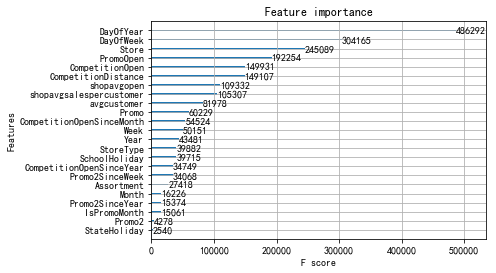

In [106]:
xgb.plot_importance(xgboost_tree)

In [192]:
rmspe(y_val, np.expm1(xgboost_tree.predict(X_val)))

0.10926603952528588

In [ ]:
test_pred= np.expm1(xgboost_tree.predict(test.drop('Id',axis=1)))
test_excel=pd.read_csv('C:/Users/Raytine/Desktop/rossmann-store-sales/sample_submission.csv')
test_excel['Sales']=test_pred
writer=pd.ExcelWriter('C:/Users/Raytine/Desktop/rossmann-store-sales/sample_submission.xlsx')
test_excel.to_excel(writer,sheet_name='sample_submission')
writer.save()

In [187]:
test.DayOfYear.min()

213

(array([2.000e+00, 1.600e+01, 6.900e+01, 1.610e+02, 3.380e+02, 6.450e+02,
        1.104e+03, 1.567e+03, 2.070e+03, 2.874e+03, 3.517e+03, 4.110e+03,
        4.664e+03, 4.858e+03, 4.879e+03, 4.970e+03, 4.828e+03, 4.444e+03,
        4.267e+03, 3.952e+03, 3.710e+03, 3.429e+03, 2.923e+03, 2.550e+03,
        2.296e+03, 1.981e+03, 1.841e+03, 1.498e+03, 1.393e+03, 1.110e+03,
        1.016e+03, 9.390e+02, 7.470e+02, 6.440e+02, 5.830e+02, 4.780e+02,
        4.160e+02, 3.230e+02, 2.830e+02, 2.600e+02, 2.220e+02, 2.390e+02,
        2.040e+02, 1.840e+02, 1.620e+02, 1.250e+02, 1.220e+02, 1.110e+02,
        1.000e+02, 9.500e+01, 7.500e+01, 6.500e+01, 5.700e+01, 7.200e+01,
        5.400e+01, 5.100e+01, 4.900e+01, 3.600e+01, 3.200e+01, 3.200e+01,
        3.800e+01, 2.700e+01, 2.300e+01, 2.100e+01, 1.400e+01, 1.800e+01,
        1.400e+01, 1.200e+01, 1.100e+01, 5.000e+00, 1.000e+01, 4.000e+00,
        5.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

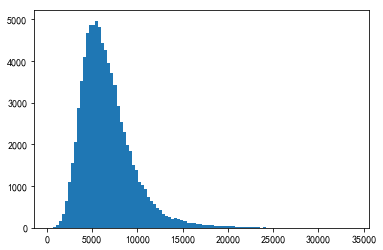

In [188]:
plt.hist(train_data[(train_data['DayOfYear']<=260)&(train_data['DayOfYear']>=213)]['Sales'],bins=100)

(array([1.400e+01, 1.800e+01, 1.240e+02, 2.460e+02, 5.040e+02, 7.150e+02,
        9.330e+02, 1.463e+03, 1.835e+03, 1.957e+03, 2.385e+03, 2.553e+03,
        2.756e+03, 2.678e+03, 2.593e+03, 2.469e+03, 2.203e+03, 2.019e+03,
        1.843e+03, 1.686e+03, 1.551e+03, 1.262e+03, 1.084e+03, 9.090e+02,
        7.940e+02, 6.700e+02, 5.790e+02, 4.650e+02, 3.900e+02, 3.540e+02,
        2.920e+02, 2.420e+02, 1.930e+02, 1.740e+02, 1.500e+02, 1.100e+02,
        1.020e+02, 6.400e+01, 7.100e+01, 6.500e+01, 6.000e+01, 4.900e+01,
        6.000e+01, 4.400e+01, 2.700e+01, 2.200e+01, 2.900e+01, 2.700e+01,
        2.400e+01, 1.800e+01, 1.700e+01, 2.000e+01, 1.900e+01, 1.200e+01,
        1.800e+01, 2.100e+01, 1.000e+01, 1.300e+01, 8.000e+00, 1.000e+01,
        5.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 9.000e+00, 2.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

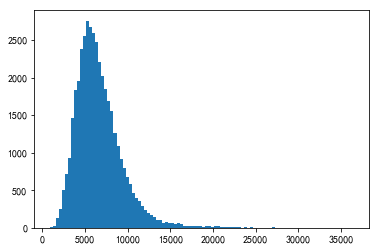

In [184]:
plt.hist(test_pred,bins=100)